# UMAP small molecules

In [22]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap
import duckdb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
;

''

# UMAP for ECFP4

In [23]:
RUN_DIR = '/Users/sethhowes/Desktop/FS-Tox/multirun/2023-07-31/14-49-41'
run_dirs = os.listdir(RUN_DIR)
ecfp4_feature_dirs = [f"{RUN_DIR}/{run_dir}/data/processed/feature/ecfp4_1024.parquet" for run_dir in run_dirs if all(x not in run_dir for x in [".DS_Store", "multirun.yaml"])]
ecfp4_feature_dirs = [run_dir for run_dir in ecfp4_feature_dirs if 'chemberta' not in run_dir]

In [24]:
ecfp4_assay_dirs = [f"{RUN_DIR}/{run_dir}/data/processed/assay" for run_dir in run_dirs if all(x not in run_dir for x in [".DS_Store", "multirun.yaml"]) and ('chemberta' not in run_dir)]

In [25]:
con = duckdb.connect()

dfs = []

for assay_dir, feature_dir in zip(ecfp4_assay_dirs, ecfp4_feature_dirs):
    query = f"""
    SELECT *
    FROM read_parquet('{assay_dir}/*') as A
    JOIN read_parquet('{feature_dir}') as B ON A.canonical_smiles = B.canonical_smiles
    """
    df = con.execute(query).df()
    dfs.append(df)
    
full_df = pd.concat(dfs)

In [26]:
full_df.head()

,canonical_smiles,ground_truth,support_query,assay_id,source_id,canonical_smiles_2,bit_0,bit_1,bit_2,bit_3,...,bit_1015,bit_1016,bit_1017,bit_1018,bit_1019,bit_1020,bit_1021,bit_1022,bit_1023,representation
0,NC(=O)c1ncn(CC2(CO)CCC2)c1N,1,1,cd30091d598d9fe,nci60,NC(=O)c1ncn(CC2(CO)CCC2)c1N,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ecfp4_1024
1,N=c1ccn(C2OC(CO)C3O[Sn](c4ccccc4)(c4ccccc4)OC3...,1,1,cd30091d598d9fe,nci60,N=c1ccn(C2OC(CO)C3O[Sn](c4ccccc4)(c4ccccc4)OC3...,0,0,0,0,...,0,0,0,0,1,0,0,0,0,ecfp4_1024
2,c1ccc(C2=NOC3(c4ccccc4)CC(c4cccs4)Sc4ccccc4N23...,1,0,cd30091d598d9fe,nci60,c1ccc(C2=NOC3(c4ccccc4)CC(c4cccs4)Sc4ccccc4N23...,0,0,0,0,...,0,0,0,0,1,0,0,0,0,ecfp4_1024
3,N=c1[nH]c(=S)c2ncn(C3OC(CO)C(O)C3O)c2[nH]1.Nc1...,0,1,cd30091d598d9fe,nci60,N=c1[nH]c(=S)c2ncn(C3OC(CO)C(O)C3O)c2[nH]1.Nc1...,0,0,0,0,...,0,0,0,0,1,0,0,0,0,ecfp4_1024
4,CN(C)CC1CCC2=C(C1=O)C(c1ccc(Cl)c(Cl)c1)C1=C(CC...,0,1,cd30091d598d9fe,nci60,CN(C)CC1CCC2=C(C1=O)C(c1ccc(Cl)c(Cl)c1)C1=C(CC...,0,0,0,0,...,0,0,0,0,1,0,0,0,0,ecfp4_1024


In [ ]:
# Conduct stratified subsampling on full_df
sampled_df = full_df.groupby('source_id').apply(lambda x: x.sample(frac=0.05))
sampled_df.reset_index(drop=True, inplace=True)

In [ ]:
feature_df = sampled_df.drop(columns=['canonical_smiles', "support_query", "ground_truth", "assay_id", "source_id", "canonical_smiles_2", "representation"])

In [ ]:
# Create a dictionary to map source_id to colors
color_dict = {"nci60":0, "toxval":1, "toxcast":2, "prism":3, "cancerrx":4, "acute_oral_toxicity":5, "meic":6}

# Apply UMAP
data = feature_df.values
reducer = umap.UMAP(n_components=2, metric='jaccard', n_neighbors=25, min_dist=0.5, random_state=42)
embedding = reducer.fit_transform(data)

# Convert the transformed data into a DataFrame
embedding_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])

# Reset the index of sampled_df before assigning
embedding_df['source_id'] = sampled_df['source_id'].reset_index(drop=True)

# Create the scatterplot
plt.figure(figsize=(12,8))
for source_id, color in color_dict.items():
    indices_to_keep = embedding_df['source_id'] == source_id
    plt.scatter(
        embedding_df.loc[indices_to_keep, 'UMAP1'],
        embedding_df.loc[indices_to_keep, 'UMAP2'],
        c = sns.color_palette()[color],
        s = 50,
        label = source_id
    )

# Add a title and a legend
plt.title('UMAP Projection')
plt.legend()

# Display the plot
plt.show()


## PCA for ECFP4 fingerprints

In [27]:
feature_df = full_df.drop(columns=['canonical_smiles', "support_query", "ground_truth", "assay_id", "source_id", "canonical_smiles_2", "representation"])
data = feature_df.values

In [28]:
features = StandardScaler().fit_transform(data)

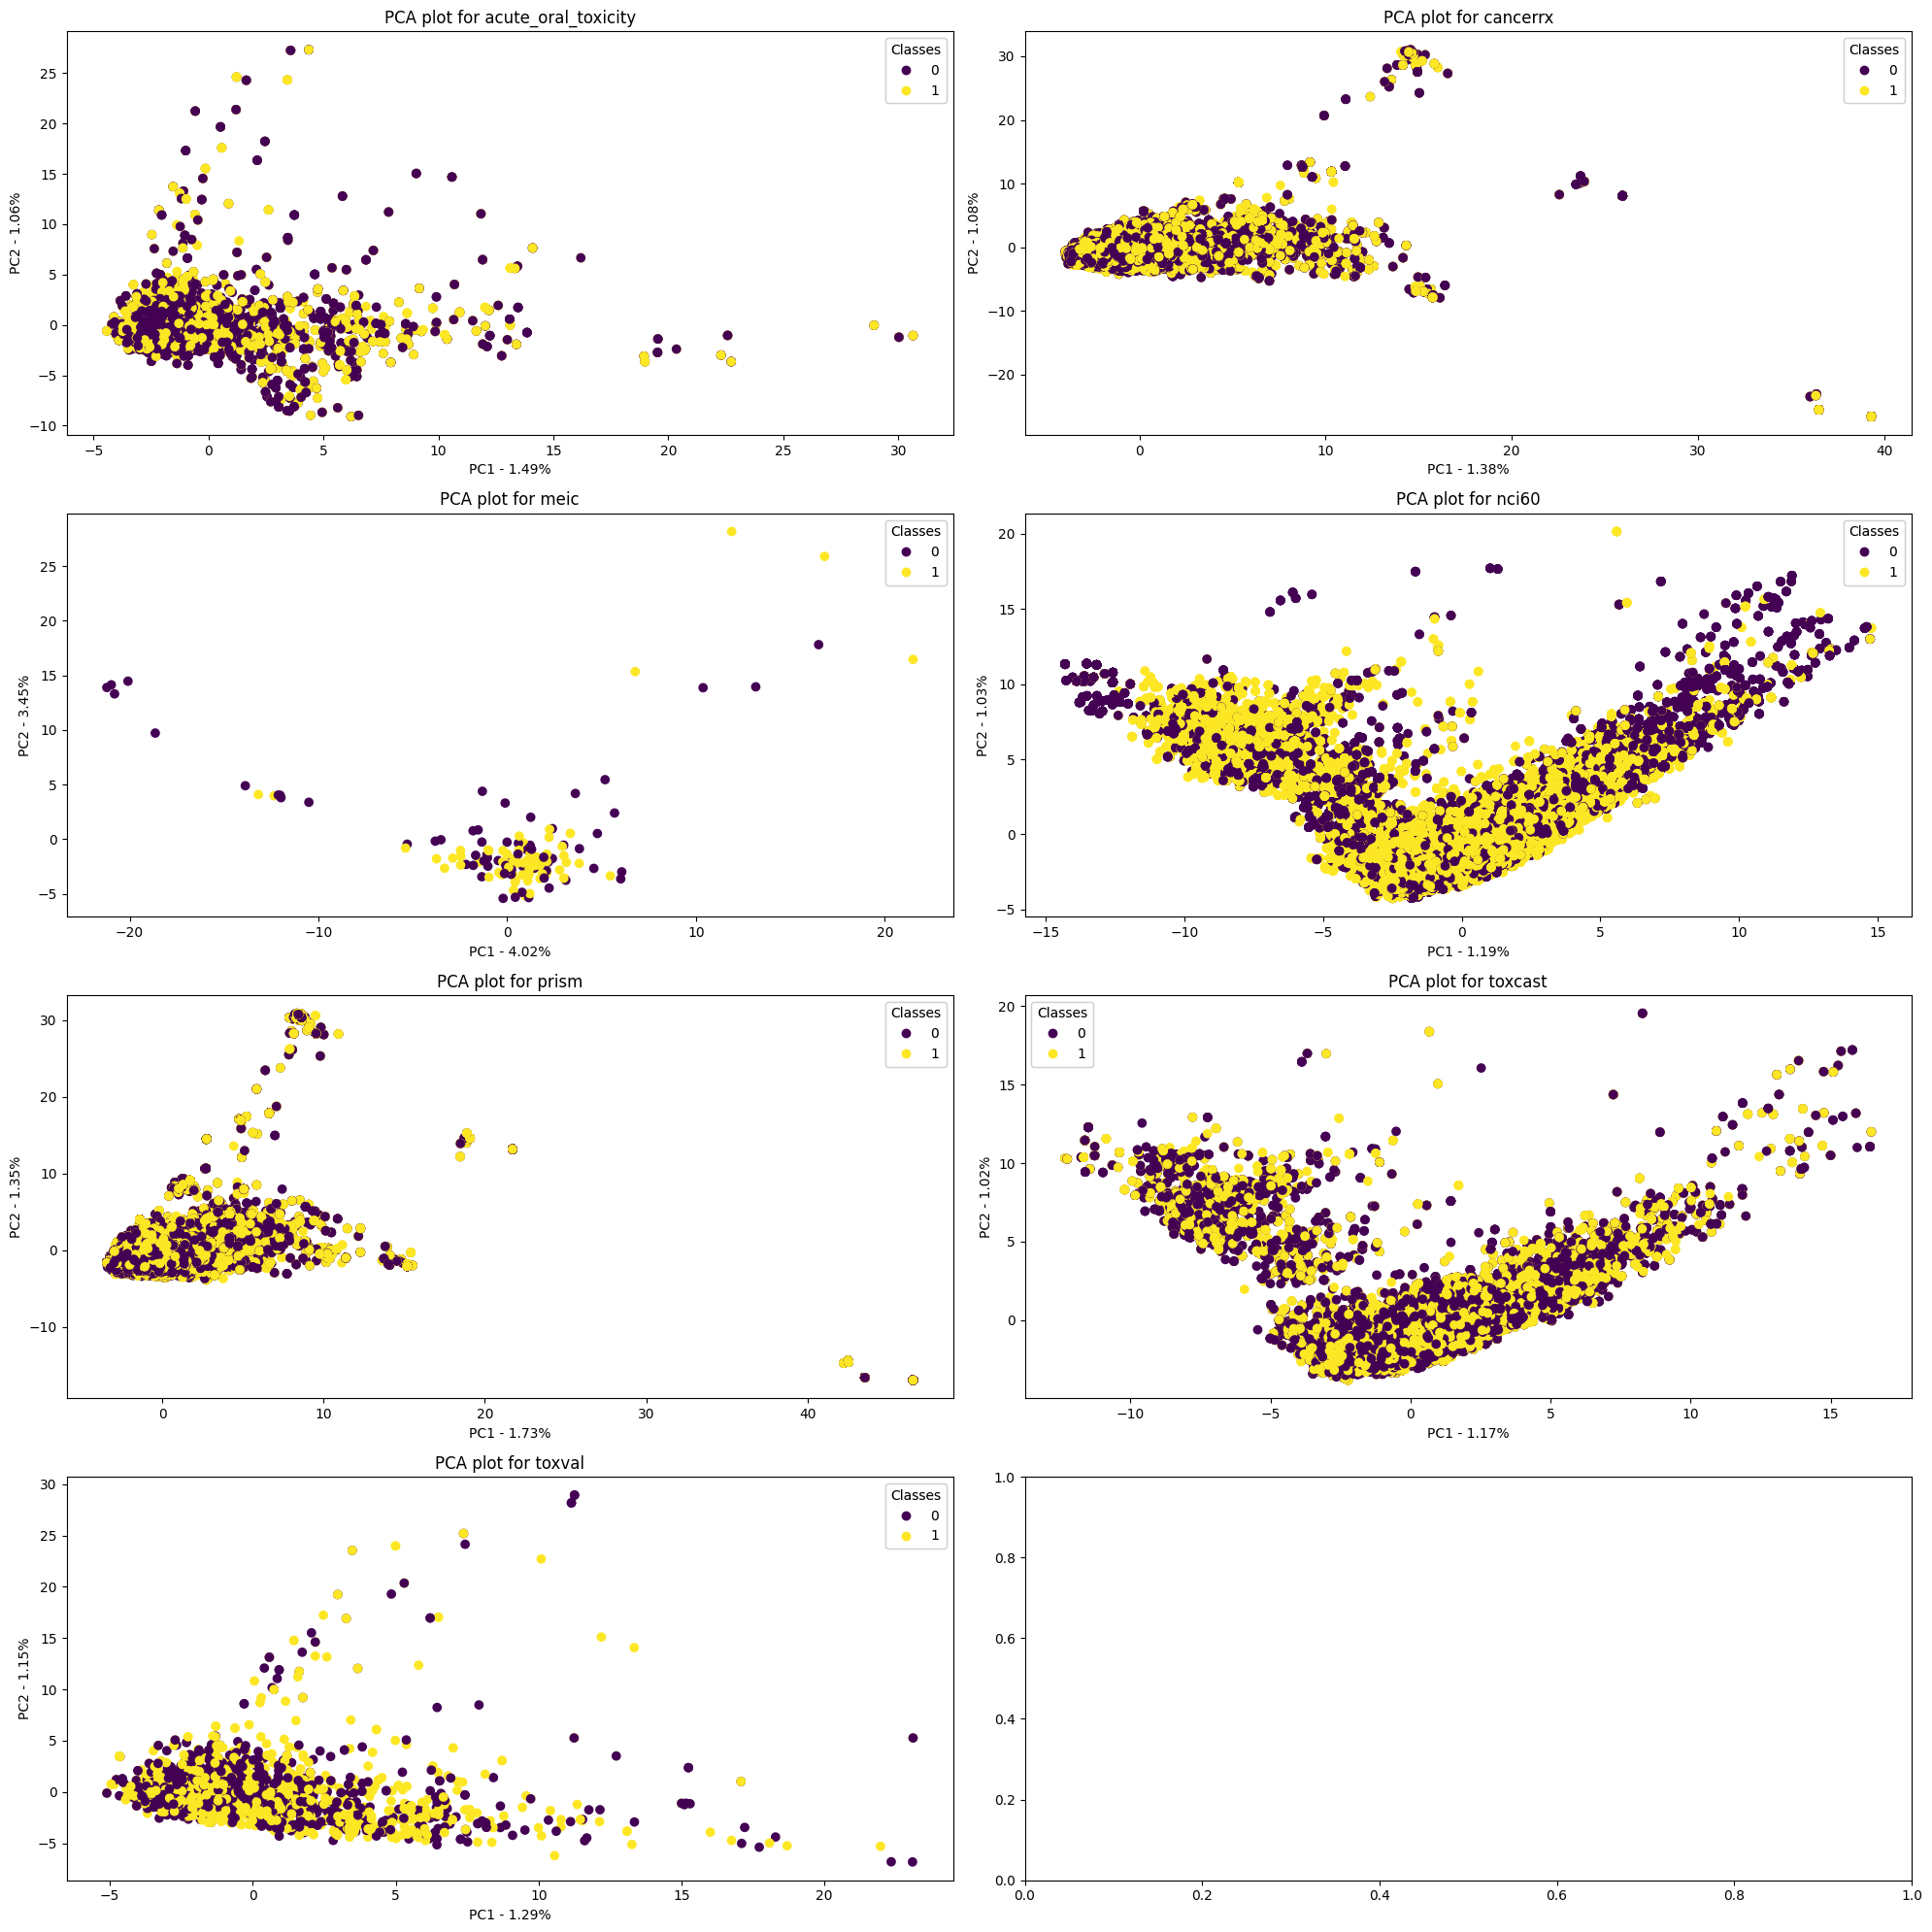

In [29]:
fig, axs = plt.subplots(4, 2, figsize=(20, 20))  # Adjust the figure size if needed

# Flatten axs for easy iteration
axs = axs.flatten()

# Get unique labels
unique_labels = sampled_df['source_id'].unique()

for ax, label in zip(axs, unique_labels):
    # Run PCA on subset
    pca = PCA(n_components=2)
    subset_df = full_df[full_df['source_id'] == label]
    subset_features = features[subset_df.index]
    principalComponents = pca.fit_transform(subset_features)

    # Create a DataFrame with the two components
    PCA_components = pd.DataFrame(principalComponents, columns=['PC1', 'PC2'])
    class_labels = subset_df['ground_truth'].astype('category').cat.codes  # Convert categories to numerical codes

    scatter = ax.scatter(PCA_components['PC1'], PCA_components['PC2'], c=class_labels, label=class_labels.unique())
    
    # Create a legend for the colors
    legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
    ax.add_artist(legend1)

    ax.set_title(f'PCA plot for {label}')
    ax.set_xlabel('PC1 - {0}%'.format(round(pca.explained_variance_ratio_[0]*100, 2)))
    ax.set_ylabel('PC2 - {0}%'.format(round(pca.explained_variance_ratio_[1]*100, 2)))

plt.tight_layout()
plt.show()

# UMAP for Chemberta embeddings

In [30]:
RUN_DIR = '/Users/sethhowes/Desktop/FS-Tox/multirun/2023-07-31/14-49-41'
run_dirs = os.listdir(RUN_DIR)
ecfp4_feature_dirs = [f"{RUN_DIR}/{run_dir}/data/processed/feature/chemberta.parquet" for run_dir in run_dirs if all(x not in run_dir for x in [".DS_Store", "multirun.yaml"])]
ecfp4_feature_dirs = [run_dir for run_dir in ecfp4_feature_dirs if 'ecfp4_1024' not in run_dir]

In [31]:
ecfp4_assay_dirs = [f"{RUN_DIR}/{run_dir}/data/processed/assay" for run_dir in run_dirs if all(x not in run_dir for x in [".DS_Store", "multirun.yaml"]) and ('ecfp4_1024' not in run_dir)]

In [32]:
con = duckdb.connect()

dfs = []

for assay_dir, feature_dir in zip(ecfp4_assay_dirs, ecfp4_feature_dirs):
    query = f"""
    SELECT *
    FROM read_parquet('{assay_dir}/*') as A
    JOIN read_parquet('{feature_dir}') as B ON A.canonical_smiles = B.canonical_smiles
    """
    df = con.execute(query).df()
    dfs.append(df)
    
full_df = pd.concat(dfs)

In [33]:
full_df.head()

,canonical_smiles,ground_truth,support_query,assay_id,source_id,canonical_smiles_2,embedding_1,embedding_2,embedding_3,embedding_4,...,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767,embedding_768,representation
0,C#CCN1C(=O)COc2cc(F)c(N3C(=O)C4=C(CCCC4)C3=O)cc21,0,1,7238ce15eeaaf5d,toxval,C#CCN1C(=O)COc2cc(F)c(N3C(=O)C4=C(CCCC4)C3=O)cc21,0.335617,-0.029257,-0.103265,0.245002,...,0.278760,-0.000823,-0.147101,-0.869048,0.881317,-0.120387,-0.027800,-0.293931,0.274189,chemberta
1,C/C(=N\C#N)N(C)Cc1ccc(Cl)nc1,0,0,7238ce15eeaaf5d,toxval,C/C(=N\C#N)N(C)Cc1ccc(Cl)nc1,0.504283,0.316195,0.518522,-0.787238,...,0.586861,-0.339545,0.144093,-0.308074,0.808003,-0.009678,-0.260198,-0.666068,0.580854,chemberta
2,C=C(C)C(=O)[O-].[CH2]CCC.[CH2]CCC.[CH2]CCC.[Sn+],1,0,7238ce15eeaaf5d,toxval,C=C(C)C(=O)[O-].[CH2]CCC.[CH2]CCC.[CH2]CCC.[Sn+],0.882055,-0.454815,-0.824038,-0.273146,...,0.427964,0.314937,-1.109617,-0.247962,0.112045,-0.233843,0.159209,-0.271709,0.504456,chemberta
3,CC(=O)O.CCCCCCCCCCCCNC(=N)N,1,1,7238ce15eeaaf5d,toxval,CC(=O)O.CCCCCCCCCCCCNC(=N)N,0.303144,0.010815,-0.779398,-0.310520,...,0.572877,0.203521,-0.193366,-0.297171,0.365113,-0.177311,-0.713682,0.326893,0.667784,chemberta
4,CC(C)(C)c1ccc(CCOc2ncnc3ccccc23)cc1,1,0,7238ce15eeaaf5d,toxval,CC(C)(C)c1ccc(CCOc2ncnc3ccccc23)cc1,1.071675,0.844936,0.350455,-0.808688,...,0.174404,-0.756880,-1.297971,-0.582837,0.192580,-0.574360,0.276980,0.071412,0.579281,chemberta


In [34]:
# Conduct stratified subsampling on full_df
sampled_df = full_df.groupby('source_id').apply(lambda x: x.sample(frac=0.05))
sampled_df.reset_index(drop=True, inplace=True)

In [17]:
feature_df = sampled_df.drop(columns=['canonical_smiles', "support_query", "ground_truth", "assay_id", "source_id", "canonical_smiles_2", "representation"])

/Users/sethhowes/miniconda3/envs/fs-tox/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:393: UserWarning: Exited at iteration 2000 with accuracies 
[1.14904619e-14 5.88343279e-07 5.82061675e-07 1.36087602e-05]
not reaching the requested tolerance 1.6838312149047852e-06.
Use iteration 1729 instead with accuracy 
1.4624459430427958e-06.

  _, diffusion_map = lobpcg(
/Users/sethhowes/miniconda3/envs/fs-tox/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:393: UserWarning: Exited postprocessing with accuracies 
[1.32732866e-14 5.63659142e-07 5.80651435e-07 4.70547311e-06]
not reaching the requested tolerance 1.6838312149047852e-06.
  _, diffusion_map = lobpcg(
/var/folders/t1/p54ybn1n4j3_ywd21t7skv2m0000gn/T/ipykernel_61118/2742234586.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keywor

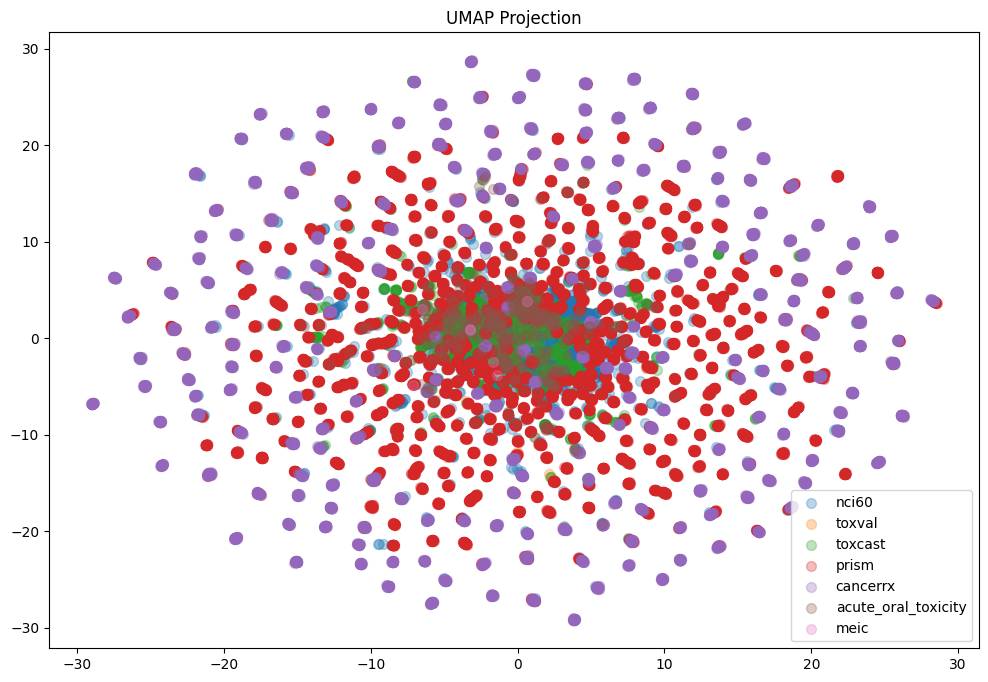

In [18]:
# Create a dictionary to map source_id to colors
color_dict = {"nci60":0, "toxval":1, "toxcast":2, "prism":3, "cancerrx":4, "acute_oral_toxicity":5, "meic":6}

# Apply UMAP
data = feature_df.values
reducer = umap.UMAP(n_components=2, metric='euclidean', n_neighbors=25, min_dist=0.5, random_state=42)
embedding = reducer.fit_transform(data)

# Convert the transformed data into a DataFrame
embedding_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
embedding_df['source_id'] = sampled_df['source_id']

# Create the scatterplot
plt.figure(figsize=(12,8))
for source_id, color in color_dict.items():
    indices_to_keep = embedding_df['source_id'] == source_id
    plt.scatter(
        embedding_df.loc[indices_to_keep, 'UMAP1'],
        embedding_df.loc[indices_to_keep, 'UMAP2'],
        alpha = 0.3,
        c = sns.color_palette()[color],
        s = 50,
        label = source_id
    )

# Add a title and a legend
plt.title('UMAP Projection')
plt.legend()

# Display the plot
plt.show()


## PCA for embeddings

In [35]:
feature_df = full_df.drop(columns=['canonical_smiles', "support_query", "ground_truth", "assay_id", "source_id", "canonical_smiles_2", "representation"])
data = feature_df.values
features = StandardScaler().fit_transform(data)

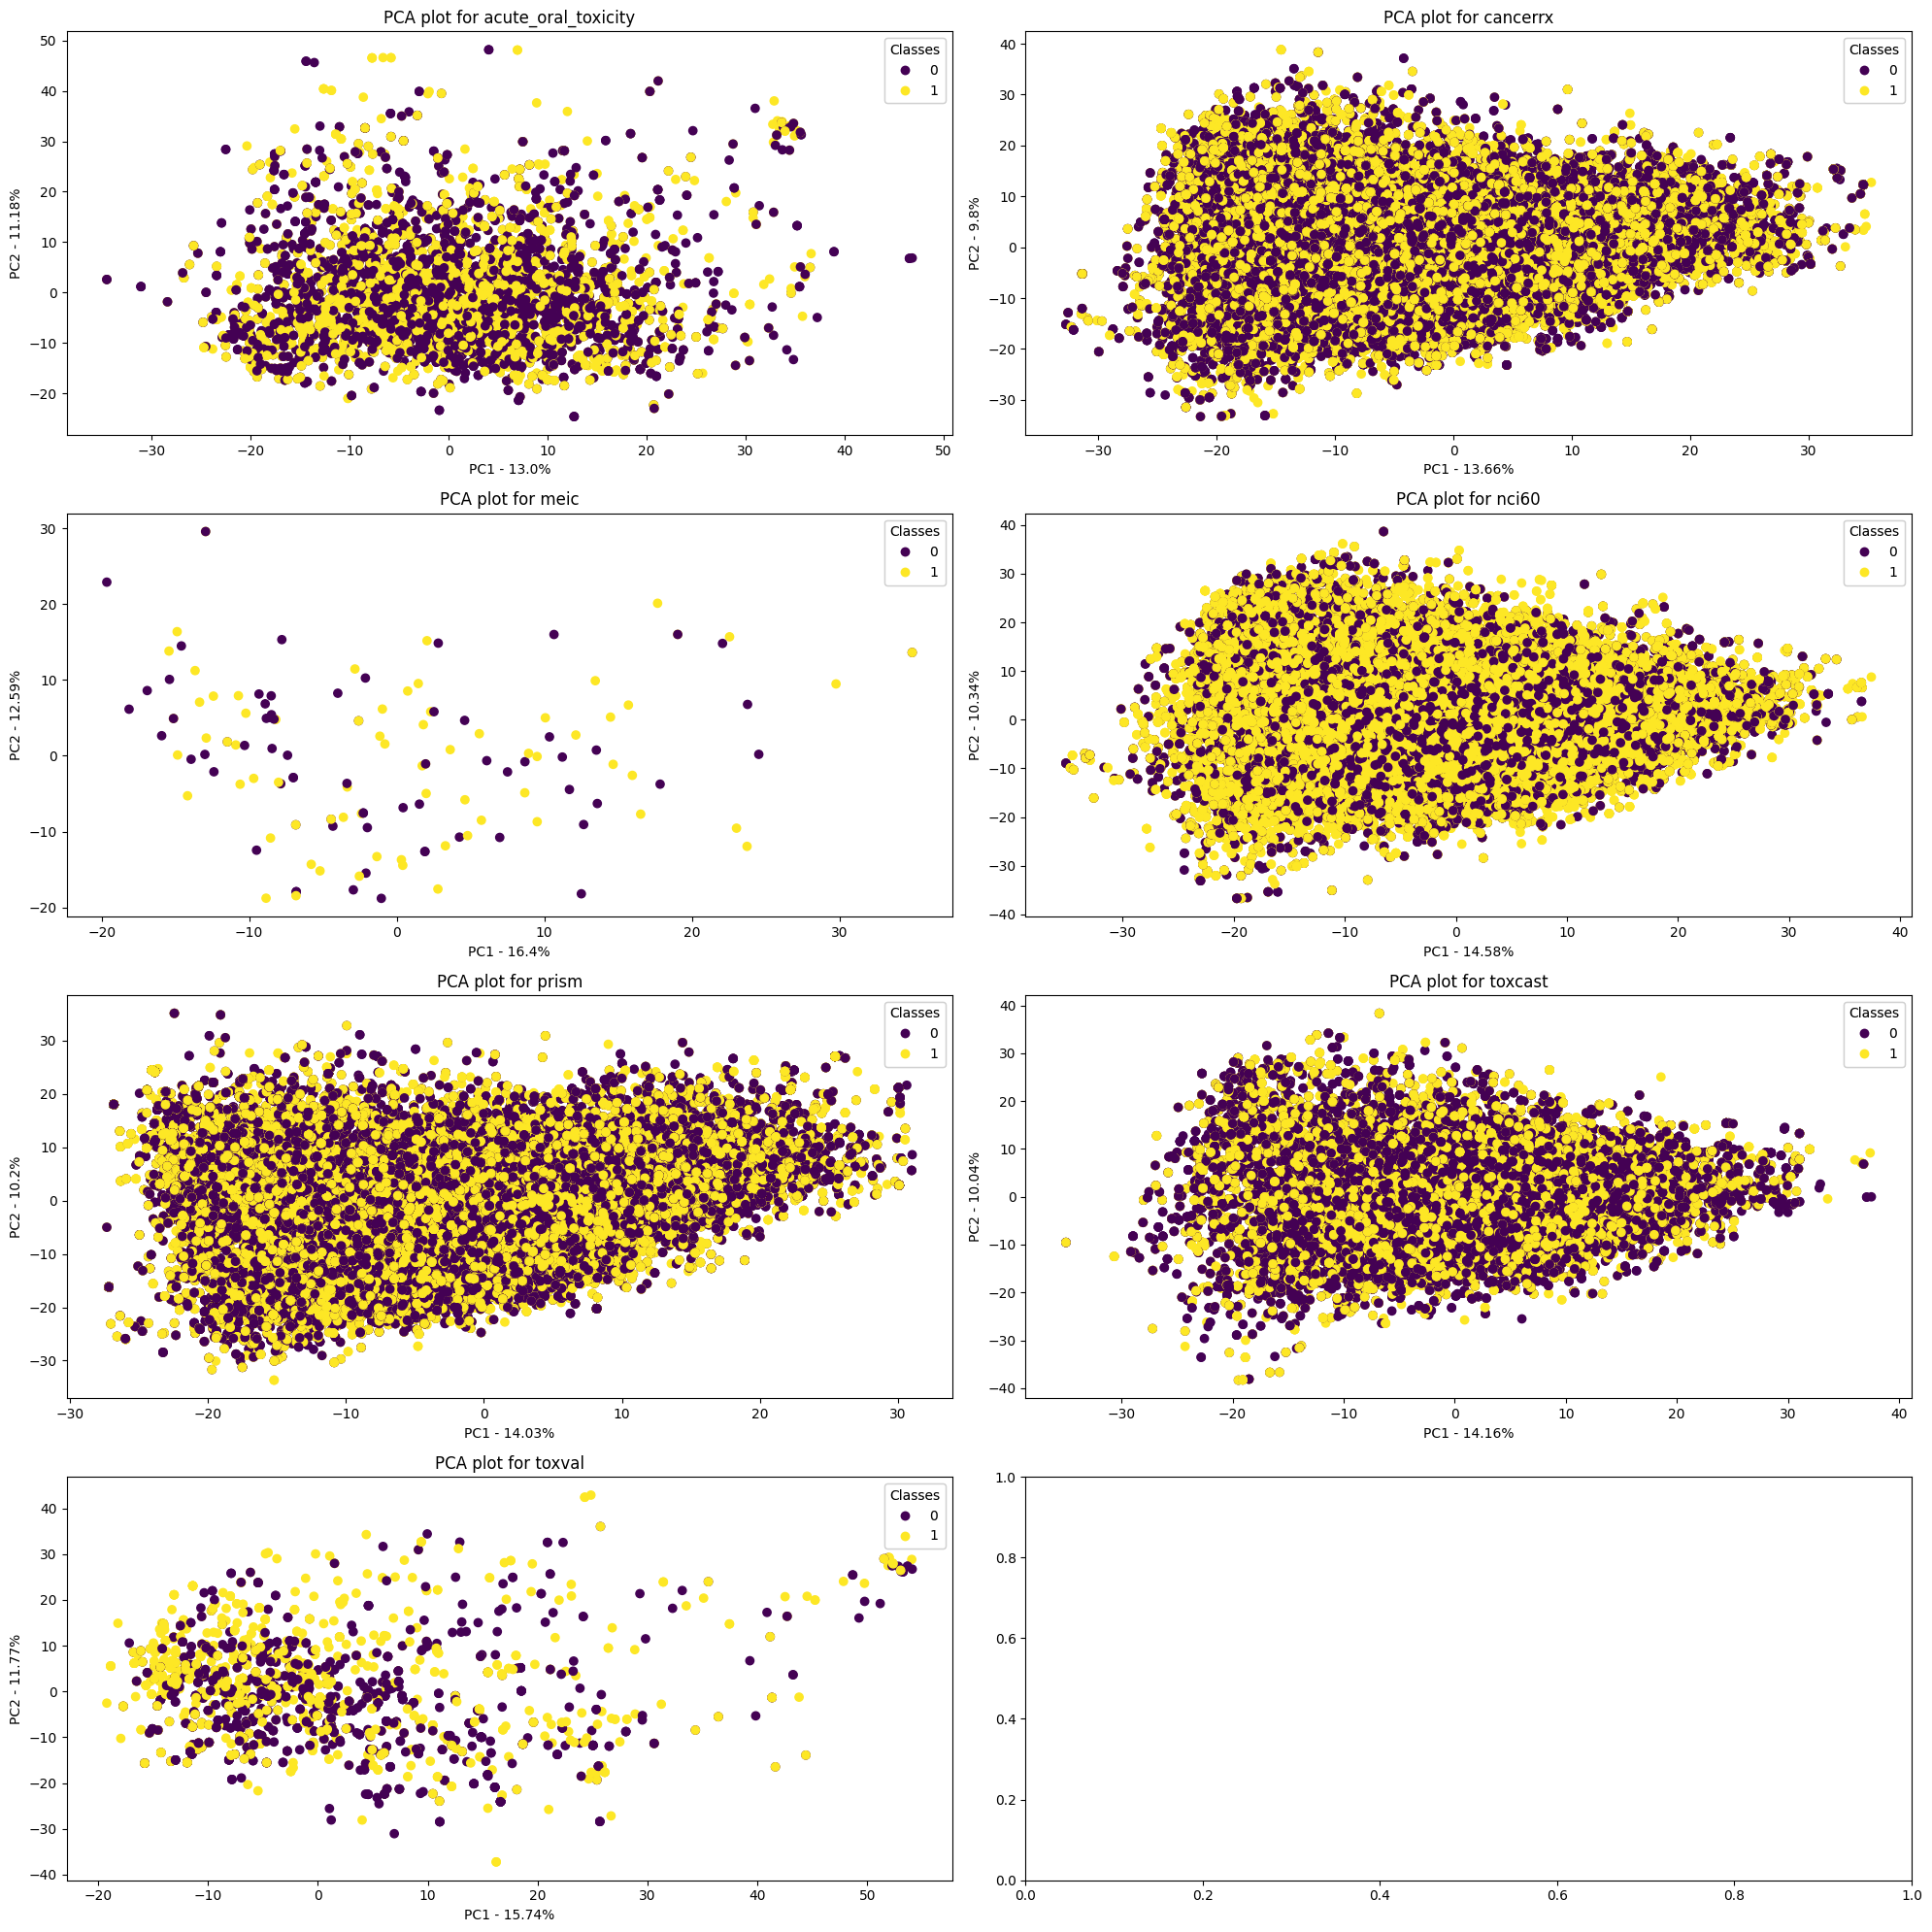

In [36]:
fig, axs = plt.subplots(4, 2, figsize=(20, 20))  # Adjust the figure size if needed

# Flatten axs for easy iteration
axs = axs.flatten()

# Get unique labels
unique_labels = sampled_df['source_id'].unique()

for ax, label in zip(axs, unique_labels):
    # Run PCA on subset
    pca = PCA(n_components=2)
    subset_df = full_df[full_df['source_id'] == label]
    subset_features = features[subset_df.index]
    principalComponents = pca.fit_transform(subset_features)

    # Create a DataFrame with the two components
    PCA_components = pd.DataFrame(principalComponents, columns=['PC1', 'PC2'])
    class_labels = subset_df['ground_truth'].astype('category').cat.codes  # Convert categories to numerical codes

    scatter = ax.scatter(PCA_components['PC1'], PCA_components['PC2'], c=class_labels, label=class_labels.unique())
    
    # Create a legend for the colors
    legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
    ax.add_artist(legend1)

    ax.set_title(f'PCA plot for {label}')
    ax.set_xlabel('PC1 - {0}%'.format(round(pca.explained_variance_ratio_[0]*100, 2)))
    ax.set_ylabel('PC2 - {0}%'.format(round(pca.explained_variance_ratio_[1]*100, 2)))

plt.tight_layout()
plt.show()